<a href="https://colab.research.google.com/github/Alphonsce/molecular_modeling/blob/main/molecular_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from math import sqrt, pow

np.random.seed(1)

In [5]:
SIGMA = 1
EPSILON = 1
M = 1

TIME_STEPS = 10000
N = 20
L = 2 * N ** (1 / 3)
r_cut = 2.5     # the distance of cut for the LJ potential

dt = 0.001
# T is in epsilon / k_b units; we need to rescale velocities for temperature to be our set value
T_thermostat = 0.8

In [6]:
class Particle:
    '''
    class, which will represent a moving particle
    '''
    def __init__(self, pos, vel, acc):
        self.pos = pos
        self.vel = vel
        self.acc = acc

        self.kin_energy = 0     # 0.5 * M * norm(vel) ** 2
        self.pot_energy = 0

    def move(self):
        self.pos += self.vel * dt + 0.5 * self.acc * dt ** 2
        # boundary conditions:
        for r_i in self.pos:
            if r_i > L:
                r_i -= L
            if r_i < L:
                r_i += L

In [7]:
def initialize_system():
    '''
    initializes coordinates and velocities of particles
    '''
    particles = []
    for _ in range(N):
        pos = np.zeros(3)
        vel = np.zeros(3)
        acc = np.zeros(3)
        for i in range(3):
            pos[i] = random.uniform(0, L)
            vel[i] = random.normalvariate(0, 1)
        particles.append(Particle(pos, vel, acc))
    return particles


In [8]:
def force(r):
    '''
    r is a vector from one particle to another
    '''
    d = norm(r)
    f = 4 * EPSILON * (12 * (SIGMA / pow(d, 13)) - 6 * (SIGMA / pow(d, 7))) * (r / d)   # wrong power of sigma is on purpose
    return f

In [9]:
def sgn(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    return 0

In [10]:
def calculate_acceleration(part1, part2):
    r = part1.pos - part2.pos       # r_1 - r_2
    # Boundary condition realisation:
    for i in range(3):
        if abs(r[i]) > L / 2:
            r[i] = r[i] - L * sgn(r[i])
            
    dist = norm(r)
    if dist < r_cut:
        part1.acc += force(r) / M       # we add the force from only one particle acting on another to the total acc
        part2.acc -= part1.acc
        # potential of two particle interaction:
        part1.pot_energy = -4 * (1 / pow(dist, 6) - 1 / pow(dist, 12))
        part2.pot_energy = 0        # because potential works for pairs

In [11]:
def plot_energy(energies):
    time = np.arange(0, len(energies) * dt, dt)
    plt.plot(time, energies)
    plt.show()

In [12]:
def main_cycle():
    '''
    main cycle, all the movements and calculations will happen here
    '''
    particles = initialize_system()
    total_pot = 0
    total_kin = 0
    energies = np.array([])

    for ts in range(TIME_STEPS):
        total_pot = 0
        total_kin = 0
        for p in particles:
            p.acc = np.zeros(3)
            p.kin_energy = 0
            p.pot_energy = 0
        for i in range(N):
            particles[i].kin_energy = 0.5 * norm(particles[i].vel) ** 2
            for j in range(i + 1, N):
                calculate_acceleration(particles[i], particles[j])

        for p in particles:
            total_kin += p.kin_energy
            total_pot += p.pot_energy
            p.move()

        energies = np.append(energies, total_kin + total_pot)
        
        # TODO: calculate and rescale velocities here
        T_current = (2 / 3) * total_kin / N
        # scaler = sqrt(T_thermostat / T_current)
        scaler = 1
        for p in particles:
            p.vel = scaler * p.vel + 0.5 * dt * p.acc

    print(energies)
    plot_energy(energies)

[5.91381541e+05 1.33839657e+08 1.33838339e+08 ... 1.33839360e+08
 1.33839360e+08 1.33839360e+08]


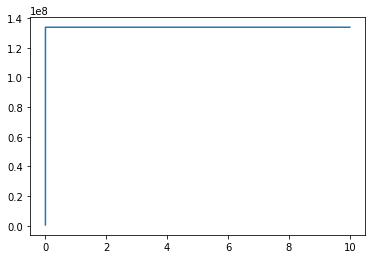

In [13]:
main_cycle()